In [1]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from functools import reduce
from operator import add
import matplotlib.pyplot as plt
import seaborn

import src.pipe as pipe

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
import xgboost as xgb

/home/ubuntu/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/ubuntu/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
def present_cv(cv):
    arr=[]
    for key in cv.keys():
        mu = np.mean(cv[key])
        st = np.std(cv[key])
        arr.append([key, mu, st])
    return pd.DataFrame(arr, columns=['metric', 'mean', 'std'])

### Without labels, with popularity

In [35]:
bbd = pipe.BillboardData() 
bbd.transform_for_models()

In [38]:
df = bbd.df.copy().drop(columns='label')

In [40]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [41]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,2.042584,0.637644
1,score_time,0.317291,0.008574
2,test_accuracy,0.860329,0.003298
3,test_recall,0.876019,0.004580
4,test_precision,0.860584,0.006791


### With dummyized labels, with popularity

In [44]:
bbd2 = pipe.BillboardData() 
bbd2.transform_for_models()
bbd2.dummyize_record_label()

In [46]:
df = bbd2.df.copy()

In [47]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [48]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,1.242959,0.349816
1,score_time,0.315201,0.006140
2,test_accuracy,0.910237,0.002000
3,test_recall,0.993703,0.002634
4,test_precision,0.912151,0.002684


### Without labels, without popularity

In [5]:
bbd = pipe.BillboardData() 
bbd.transform_for_models()
bbd.drop_popularities()

In [6]:
df = bbd.df.copy().drop(columns='label')

In [7]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [8]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,2.284604,0.702738
1,score_time,0.330756,0.016285
2,test_accuracy,0.686913,0.007089
3,test_recall,0.665874,0.016254
4,test_precision,0.714586,0.005682


### With dummyized labels, without popularity

In [9]:
bbd2 = pipe.BillboardData() 
bbd2.transform_for_models()
bbd2.dummyize_record_label()
bbd2.drop_popularities()

In [10]:
df = bbd2.df.copy()

In [11]:
rand = 7
_y = df.pop('on_billboard').values
_X = df.values
X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.1)

In [12]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)

cv = cross_validate(rf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'],
              n_jobs=-1, cv=5, return_train_score=False)
present_cv(cv)

,metric,mean,std
0,fit_time,1.357996,0.404128
1,score_time,0.311882,0.003410
2,test_accuracy,0.882671,0.000717
3,test_recall,0.998269,0.000771
4,test_precision,0.883550,0.000440


In [13]:
df.columns[:55]

Index(['total_tracks', 'duration_ms', 'explicit', 'danceability', 'energy',
       'acousticness', 'loudness', 'mode', 'speechiness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'wordcount', 'norm_sentiment',
       'release_year', 'track_placement', 'album_type_album',
       'album_type_compilation', 'album_type_single', 'key_0', 'key_1',
       'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
       'key_10', 'key_11', 'time_signature_0', 'time_signature_1',
       'time_signature_3', 'time_signature_4', 'time_signature_5',
       'release_month_1.0', 'release_month_2.0', 'release_month_3.0',
       'release_month_4.0', 'release_month_5.0', 'release_month_6.0',
       'release_month_7.0', 'release_month_8.0', 'release_month_9.0',
       'release_month_10.0', 'release_month_11.0', 'release_month_12.0',
       'lt_12_label', 'label_19recordings', 'label_19recordingslimited',
       'label_300entertainment', 'label_305', 'label_a1'],
      dtype='o

In [16]:
fi = rf.fit(X_train, y_train).feature_importances_

In [17]:
len(fi)

219

In [18]:
len(df.columns)

219

Feature ranking:
1. feature wordcount (0.065252)
2. feature track_placement (0.060137)
3. feature duration_ms (0.054068)
4. feature loudness (0.049276)
5. feature speechiness (0.046837)
6. feature valence (0.046603)
7. feature acousticness (0.046348)
8. feature energy (0.045818)
9. feature danceability (0.045508)
10. feature tempo (0.045338)
11. feature liveness (0.044219)
12. feature total_tracks (0.043127)
13. feature norm_sentiment (0.040549)
14. feature release_year (0.034560)
15. feature instrumentalness (0.030824)
16. feature lt_12_label (0.010648)
17. feature mode (0.009101)
18. feature release_month_1.0 (0.008037)
19. feature explicit (0.007456)
20. feature album_type_single (0.006190)
21. feature key_1 (0.005818)
22. feature release_month_11.0 (0.005223)
23. feature key_7 (0.005007)
24. feature key_2 (0.004856)
25. feature key_0 (0.004839)
26. feature key_8 (0.004703)
27. feature key_11 (0.004667)
28. feature key_6 (0.004576)
29. feature release_month_10.0 (0.004516)
30. featu

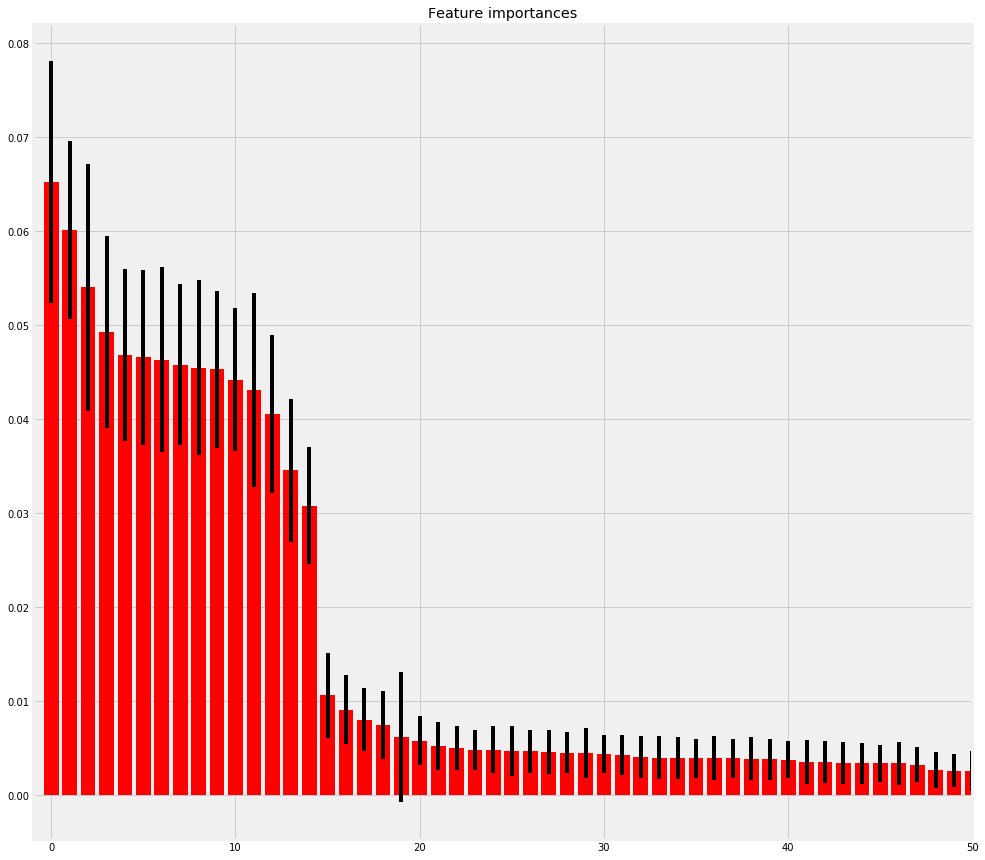

In [36]:
X=X_train
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

max_feats=50

for f in range(min(X.shape[1],max_feats)):
    print("%d. feature %s (%f)" % (f + 1, df.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, min(X.shape[1], max_feats)])
plt.show()

In [ ]:
plt.xticks()